# Spaceship Titanic

#### Импорт библиотек

In [233]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, recall_score, precision_score, precision_recall_curve, RocCurveDisplay, ConfusionMatrixDisplay, PrecisionRecallDisplay
from sklearn.model_selection import train_test_split, RandomizedSearchCV

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

#### Загрузим данные

##### Признаки

`PassengerId` — уникальный идентификатор каждого пассажира.

`HomePlanet` - планета, с которой отправился пассажир, обычно планета его постоянного места жительства.

`CryoSleep` - согласился ли пассажир на пребывание в состоянии анабиоза на время путешествия.

`Cabin` - Номер каюты, в которой находится пассажир. Задаётся в формате deck/num/side, где side может быть P (левый борт) или S (правый борт).

`Destination` - Планета, на которую высадится пассажир.

`Age` - Возраст пассажира

`VIP` - VIP-обслуживание во время рейса.

`RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` - Сумма, которую пассажир оплатил за каждое из многочисленных роскошных удобств Spaceship Titanic.

`Name` - Имя и фамилия пассажира.

`Transported` - Перевез ли пассажир в другое измерение. Это столбец, который вы пытаетесь предсказать.

In [234]:
data = pd.read_csv('data/train.csv')
data

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


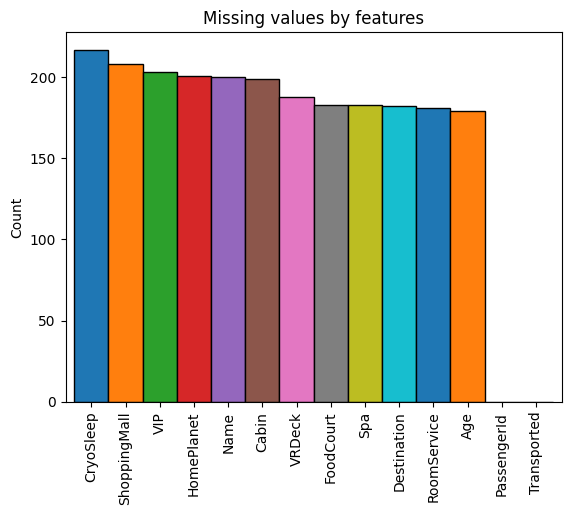

In [235]:
data.isna().sum().sort_values(ascending=False).plot(kind='bar', edgecolor='black', color=mcolors.TABLEAU_COLORS, width=1)
plt.title('Missing values by features')
plt.ylabel('Count')
plt.show()

In [236]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


#### Баланс классов

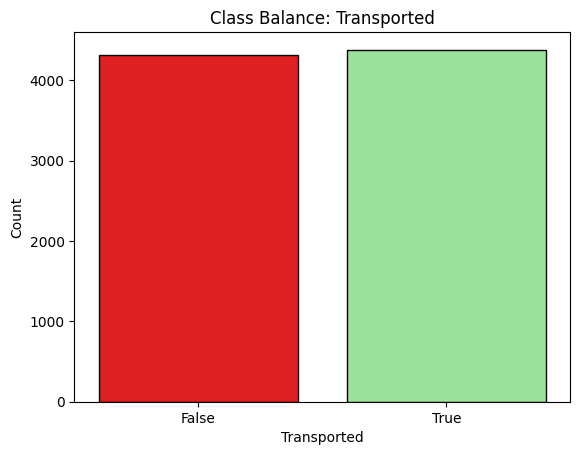

In [237]:
sns.countplot(x='Transported', data=data, palette=['red', 'lightgreen'], hue='Transported', legend=False, edgecolor='black')
plt.title('Class Balance: Transported')
plt.xlabel('Transported')
plt.ylabel('Count')
plt.show()

#### Посмотрим на все признаки

##### Категориальные:

`HomePlanet`

In [238]:
data['HomePlanet'].unique()

array(['Europa', 'Earth', 'Mars', nan], dtype=object)

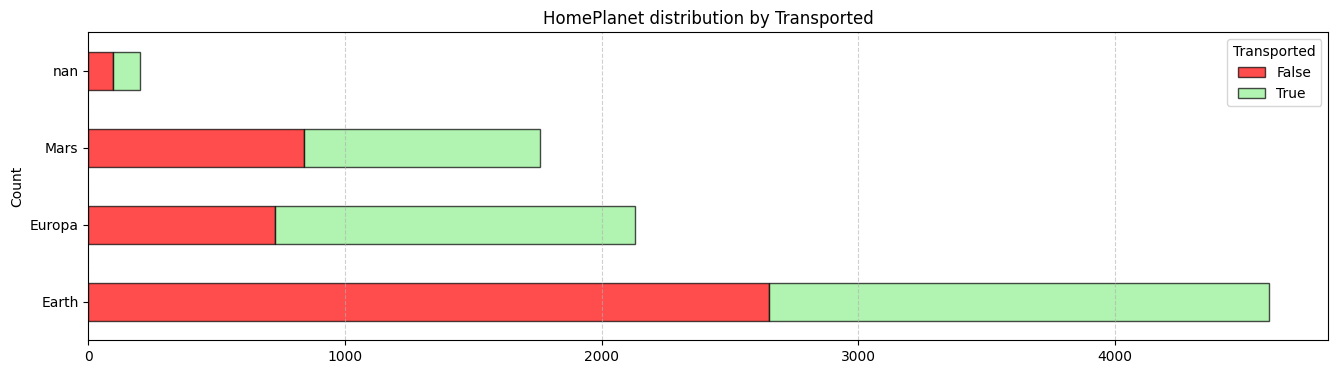

In [239]:
data.groupby(['HomePlanet', 'Transported'], dropna=False).size().unstack().plot(kind='barh', stacked=True, color=['red', 'lightgreen'], edgecolor='black', alpha=0.7, figsize=(16,4))
plt.title('HomePlanet distribution by Transported')
plt.ylabel('Count')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

In [240]:
data['HomePlanet_num'] = data['HomePlanet'].apply(lambda x: ['Earth', 'Europa', 'Mars', np.nan].index(x))

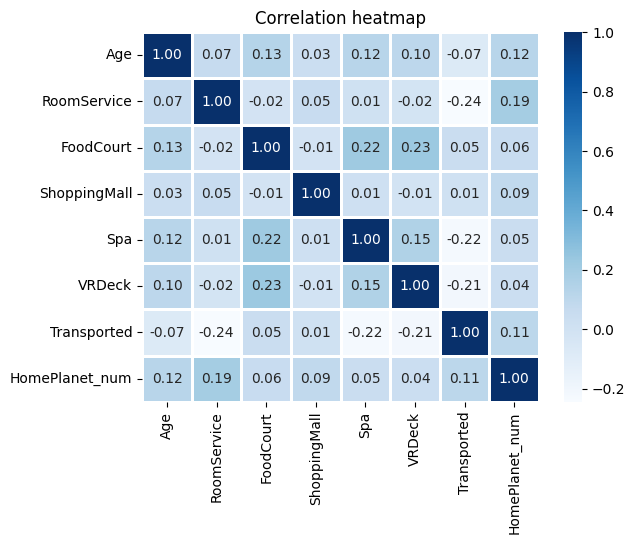

In [241]:
ax = sns.heatmap(data.corr(numeric_only=True), annot=True, cmap='Blues', linewidths=2)
for t in ax.texts: 
    t.set_text(f'{float(t.get_text()):.2f}')
plt.title('Correlation heatmap')
plt.show()

In [242]:
data.drop('HomePlanet_num', axis=1, inplace=True)

#### Признак `CryoSleep`

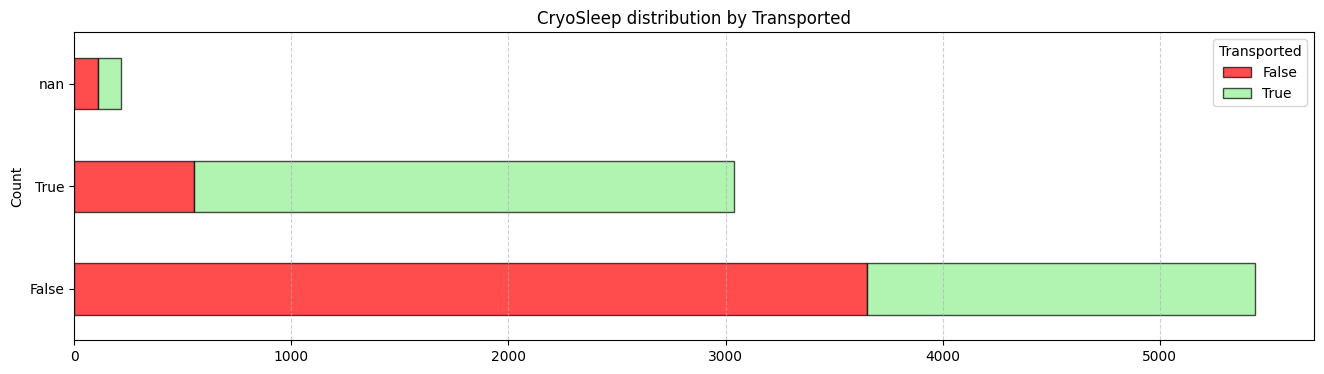

In [243]:
data.groupby(['CryoSleep', 'Transported'], dropna=False).size().unstack().plot(kind='barh', stacked=True, color=['red', 'lightgreen'], edgecolor='black', alpha=0.7, figsize=(16,4))
plt.title('CryoSleep distribution by Transported')
plt.ylabel('Count')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

In [244]:
data['CryoSleep_num'] = data['CryoSleep'].apply(lambda x: [True, False, np.nan].index(x))

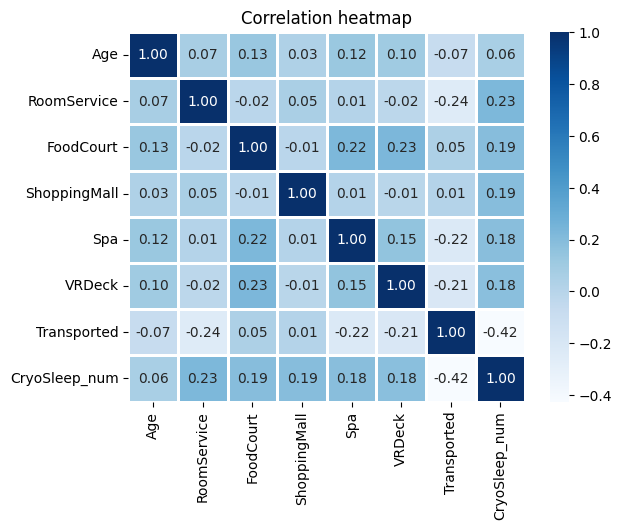

In [245]:
ax = sns.heatmap(data.corr(numeric_only=True), annot=True, cmap='Blues', linewidths=2)
for t in ax.texts: 
    t.set_text(f'{float(t.get_text()):.2f}')
plt.title('Correlation heatmap')
plt.show()

In [246]:
data.drop('CryoSleep_num', axis=1, inplace=True)

#### Признак `Cabin`

In [247]:
data['Cabin'].unique()

array(['B/0/P', 'F/0/S', 'A/0/S', ..., 'G/1499/S', 'G/1500/S', 'E/608/S'],
      shape=(6561,), dtype=object)

Разобьем на три признака

In [248]:
data['Cabin_deck'] = data['Cabin'].apply(lambda x: x.split('/')[0] if type(x) == str else np.nan)
data['Cabin_num'] = data['Cabin'].apply(lambda x: float(x.split('/')[1]) if type(x) == str else np.nan)
data['Cabin_side'] = data['Cabin'].apply(lambda x: x.split('/')[2] if type(x) == str else np.nan)

Признак `Cabin_deck`

In [249]:
data['Cabin_deck'].unique()

array(['B', 'F', 'A', 'G', nan, 'E', 'D', 'C', 'T'], dtype=object)

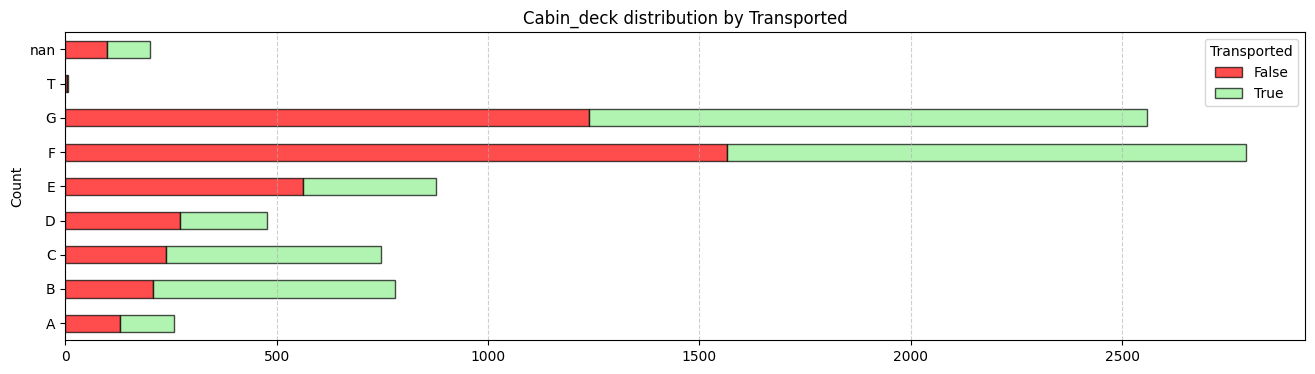

In [250]:
data.groupby(['Cabin_deck', 'Transported'], dropna=False, sort=True).size().unstack().plot(kind='barh', stacked=True, color=['red', 'lightgreen'], edgecolor='black', alpha=0.7, figsize=(16,4))
plt.title('Cabin_deck distribution by Transported')
plt.ylabel('Count')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

Признак `Cabin_num`

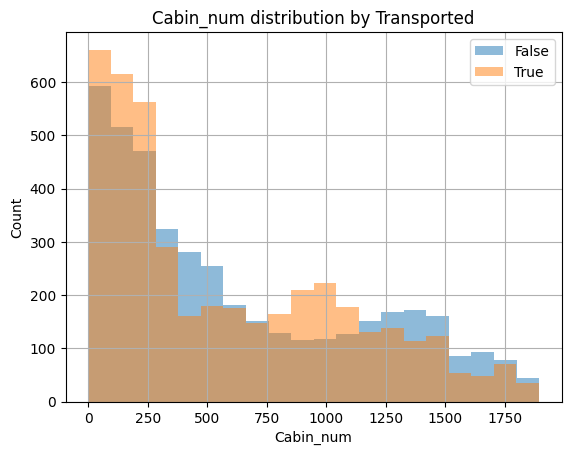

In [251]:
data.groupby('Transported')['Cabin_num'].hist(alpha=0.5, bins=20, legend=True)
plt.xlabel('Cabin_num')
plt.ylabel('Count')
plt.title('Cabin_num distribution by Transported')
plt.show()

Признак `Cabin_side`

In [252]:
data['Cabin_side'] = data['Cabin_side'].apply(lambda x: 1 if x == 'S' else 0 if x == 'P' else np.nan)

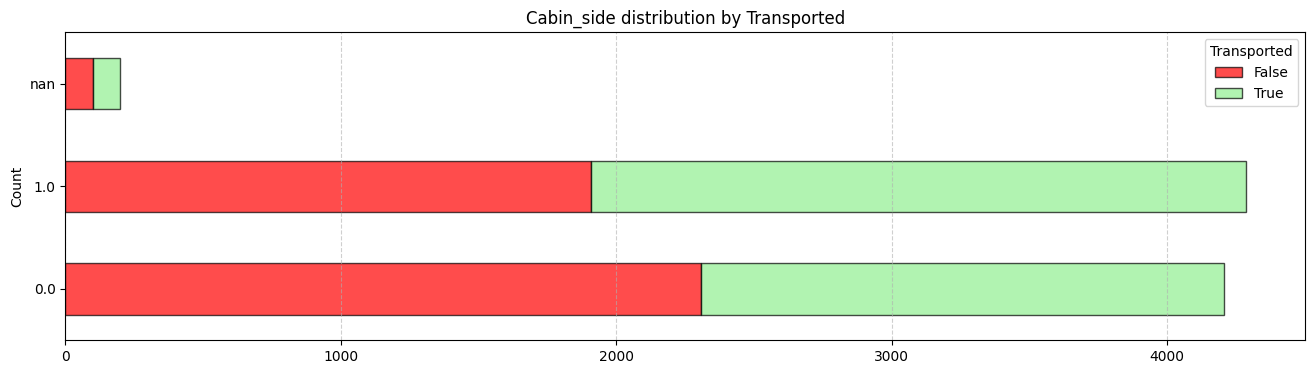

In [253]:
data.groupby(['Cabin_side', 'Transported'], dropna=False, sort=True).size().unstack().plot(kind='barh', stacked=True, color=['red', 'lightgreen'], edgecolor='black', alpha=0.7, figsize=(16,4))
plt.title('Cabin_side distribution by Transported')
plt.ylabel('Count')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

In [254]:
deck_dict = {v : i for i, v in enumerate(data['Cabin_deck'].unique())}
data['Cabin_deck'] = data['Cabin_deck'].apply(lambda x: deck_dict[x])

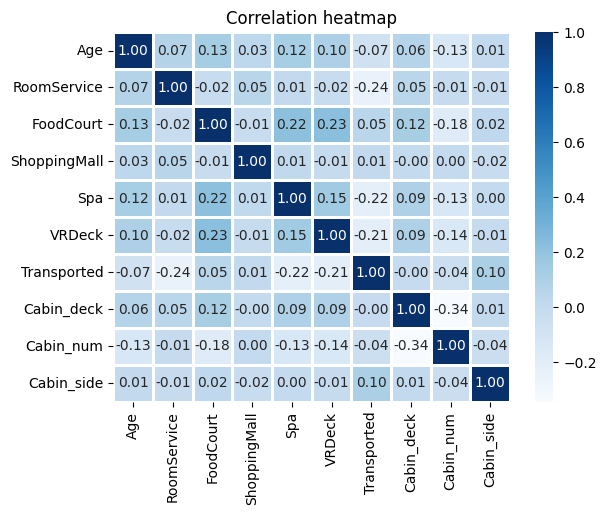

In [255]:
ax = sns.heatmap(data.corr(numeric_only=True), annot=True, cmap='Blues', linewidths=2)
for t in ax.texts: 
    t.set_text(f'{float(t.get_text()):.2f}')
plt.title('Correlation heatmap')
plt.show()

In [256]:
data.drop(labels=['Cabin_deck', 'Cabin_side', 'Cabin_num'], axis=1, inplace=True)

#### Признак `Destination`

In [257]:
data['Destination'].unique()

array(['TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e', nan], dtype=object)

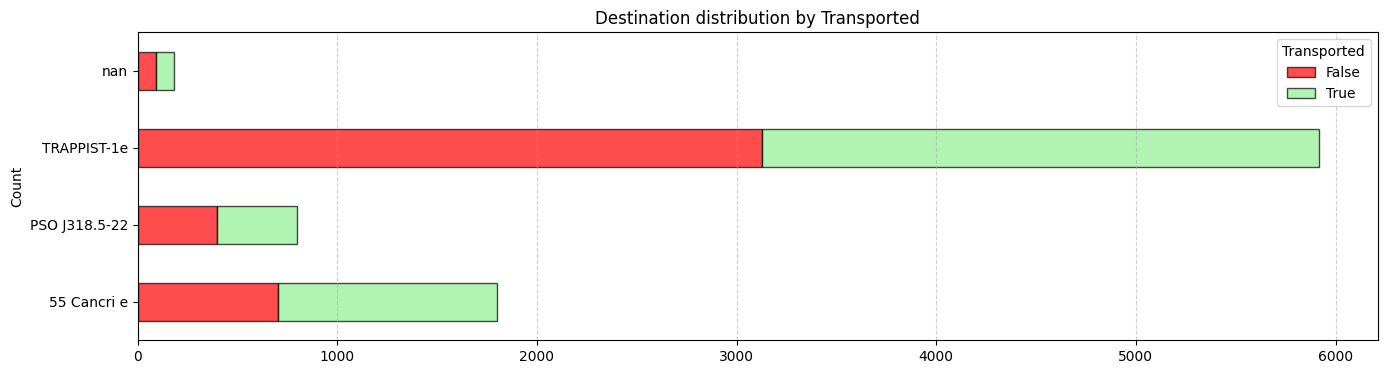

In [258]:
data.groupby(['Destination', 'Transported'], dropna=False, sort=True).size().unstack().plot(kind='barh', stacked=True, color=['red', 'lightgreen'], edgecolor='black', alpha=0.7, figsize=(16,4))
plt.title('Destination distribution by Transported')
plt.ylabel('Count')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

In [259]:
dest_dict = {v : i for i, v in enumerate(data['Destination'].unique())}
data['Destination_num'] = data['Destination'].apply(lambda x: dest_dict[x])

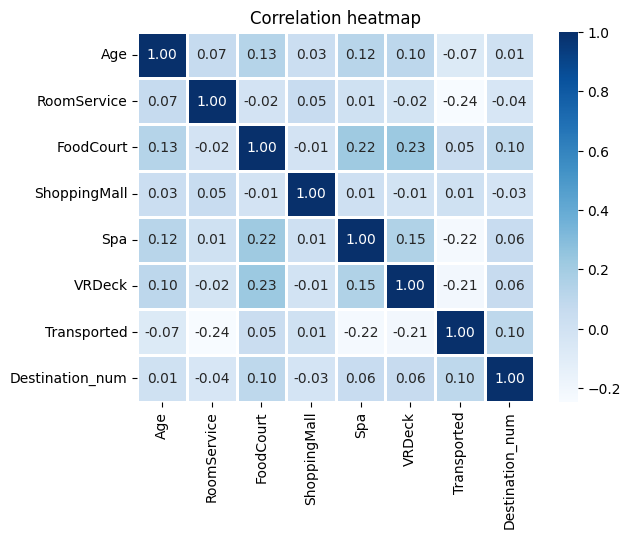

In [260]:
ax = sns.heatmap(data.corr(numeric_only=True), annot=True, cmap='Blues', linewidths=2)
for t in ax.texts: 
    t.set_text(f'{float(t.get_text()):.2f}')
plt.title('Correlation heatmap')
plt.show()

In [261]:
data.drop('Destination_num', axis=1, inplace=True)

#### Признак `Age`

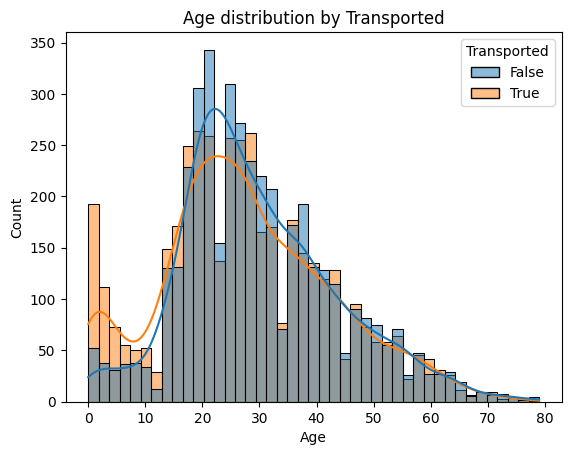

In [262]:
plt.title('Age distribution by Transported')
sns.histplot(data, x='Age', hue='Transported', kde=True)
plt.show()

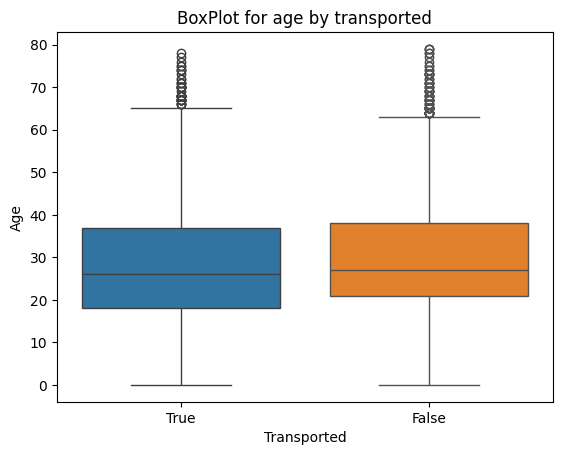

In [263]:
sns.boxplot(x='Transported', y='Age', data=data[data['Transported'] == True])
sns.boxplot(x='Transported', y='Age', data=data[data['Transported'] == False])
plt.title('BoxPlot for age by transported')
plt.show()

#### Признак `VIP`

In [264]:
data['VIP'].unique()

array([False, True, nan], dtype=object)

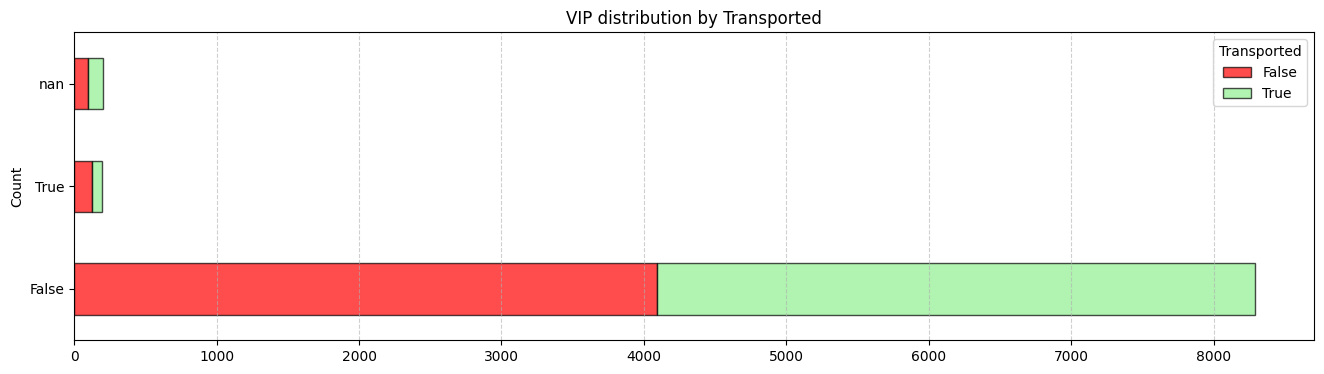

In [265]:
data.groupby(['VIP', 'Transported'], dropna=False, sort=True).size().unstack().plot(kind='barh', stacked=True, color=['red', 'lightgreen'], edgecolor='black', alpha=0.7, figsize=(16,4))
plt.title('VIP distribution by Transported')
plt.ylabel('Count')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

In [266]:
data['VIP_num'] = data['VIP'].apply(lambda x: 1 if x == True else 0 if x == False else np.nan)

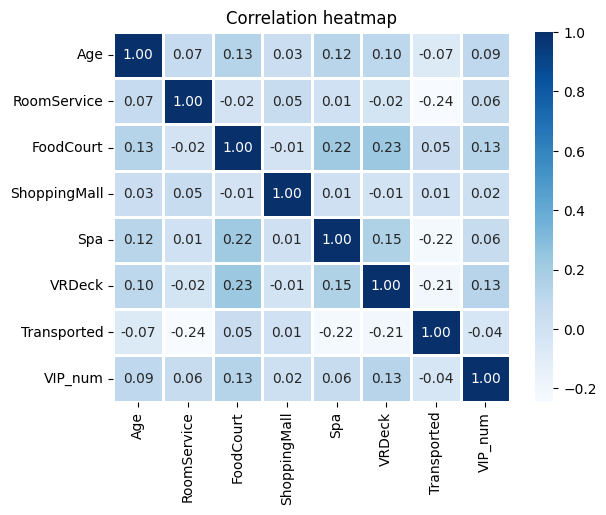

In [267]:
ax = sns.heatmap(data.corr(numeric_only=True), annot=True, cmap='Blues', linewidths=2)
for t in ax.texts: 
    t.set_text(f'{float(t.get_text()):.2f}')
plt.title('Correlation heatmap')
plt.show()

In [268]:
data.drop('VIP_num', axis=1, inplace=True)

#### Признак `Name`

In [269]:
len(data['Name'].unique()), len(data['Name']) - data['Name'].isna().sum()

(8474, np.int64(8493))

Почти все имена уникальны

#### Числовые признаки

#### Признак `PassangerId`

In [270]:
data['Team_num'] = data['PassengerId'].apply(lambda x: int(x.split('_')[0]))
data['Has_team'] = data['Team_num'].apply(lambda x: 1 if data['Team_num'].value_counts()[x] > 1 else 0)

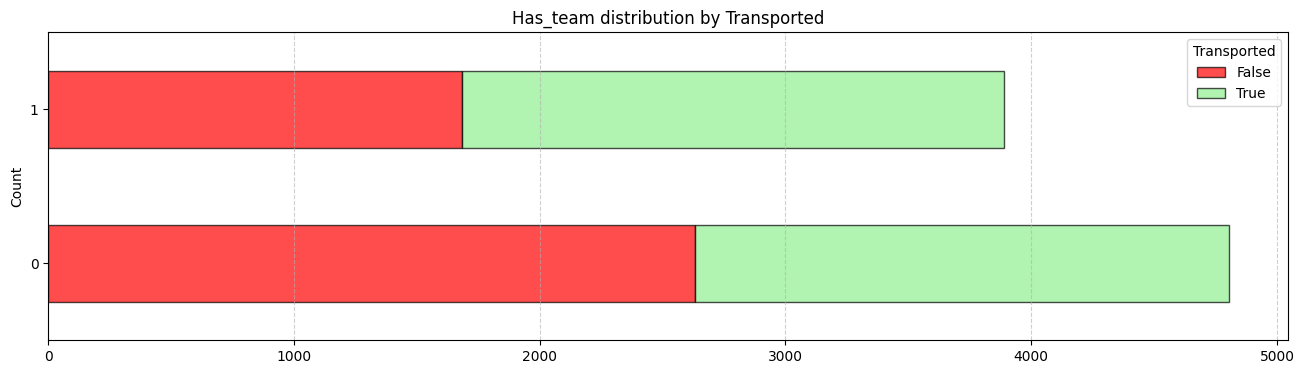

In [271]:
data.groupby(['Has_team', 'Transported'], dropna=False, sort=True).size().unstack().plot(kind='barh', stacked=True, color=['red', 'lightgreen'], edgecolor='black', alpha=0.7, figsize=(16,4))
plt.title('Has_team distribution by Transported')
plt.ylabel('Count')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

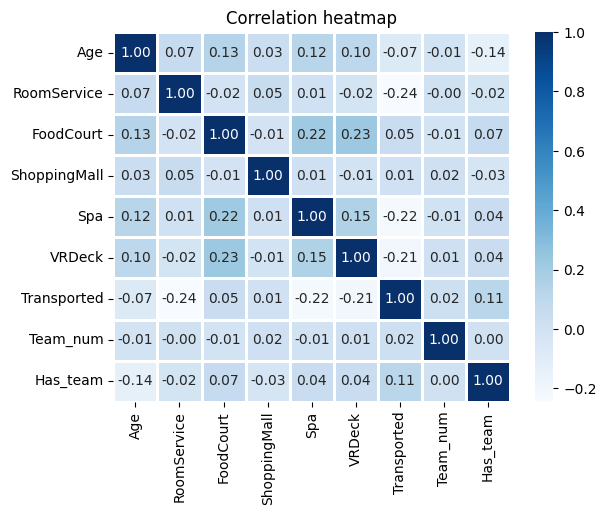

In [272]:
ax = sns.heatmap(data.corr(numeric_only=True), annot=True, cmap='Blues', linewidths=2)
for t in ax.texts: 
    t.set_text(f'{float(t.get_text()):.2f}')
plt.title('Correlation heatmap')
plt.show()

In [273]:
data.drop(labels=['Has_team', 'Team_num'], axis=1, inplace=True)

#### Признаки `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck`

In [274]:
data['TotalSpent'] = np.log1p(data[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1))

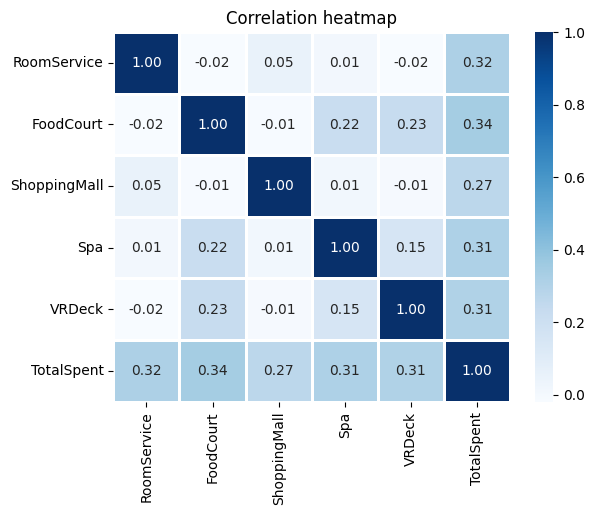

In [275]:
ax = sns.heatmap(data[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalSpent']].corr(numeric_only=True), annot=True, cmap='Blues', linewidths=2)
for t in ax.texts: 
    t.set_text(f'{float(t.get_text()):.2f}')
plt.title('Correlation heatmap')
plt.show()

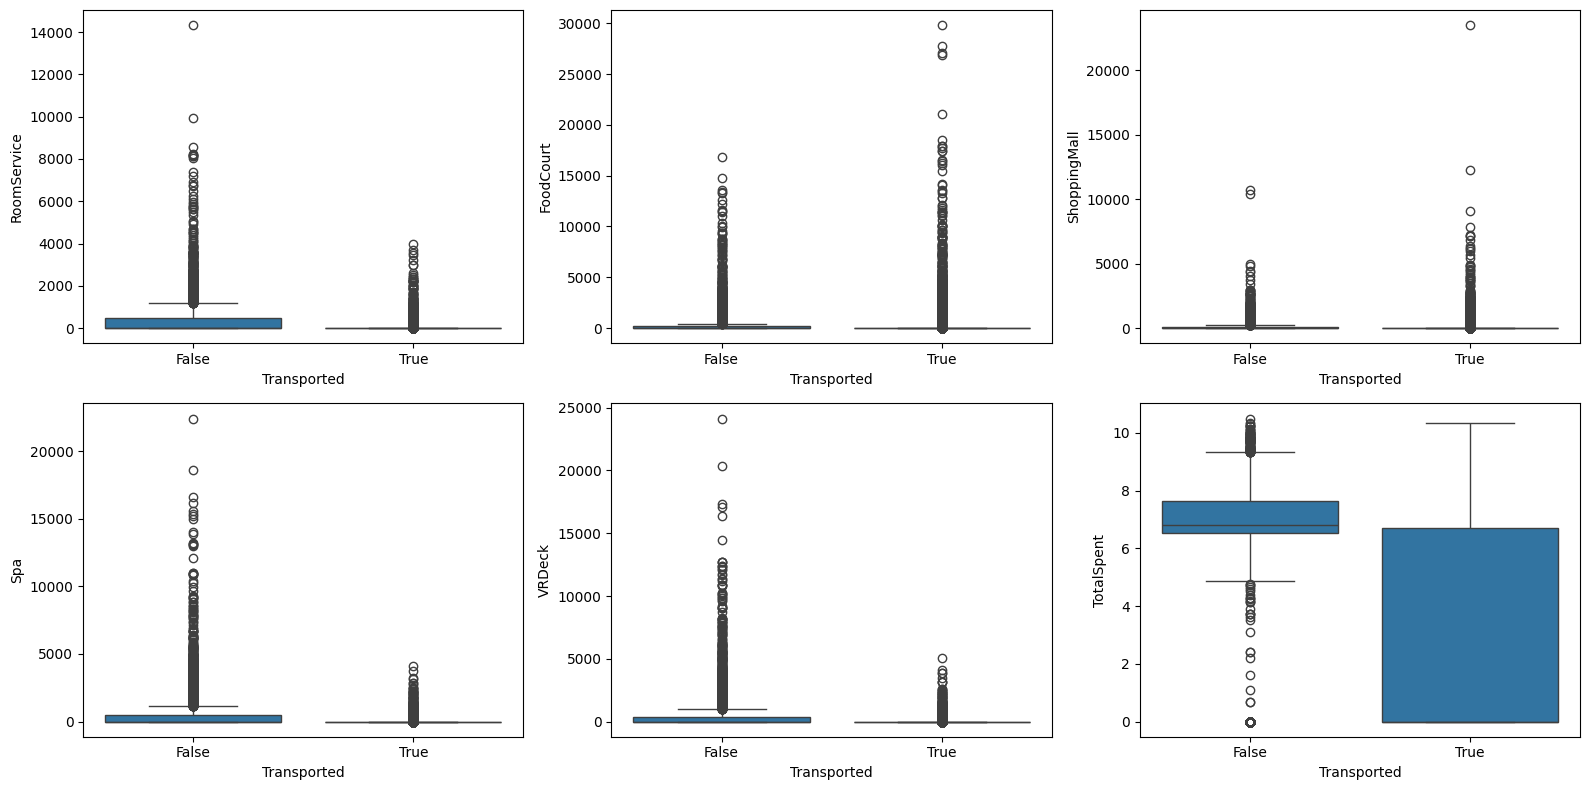

In [276]:
_, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
for f, ax in zip(['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalSpent'], axes.flatten()):
    sns.boxplot(x='Transported', y=f, data=data, ax=ax)
plt.tight_layout()

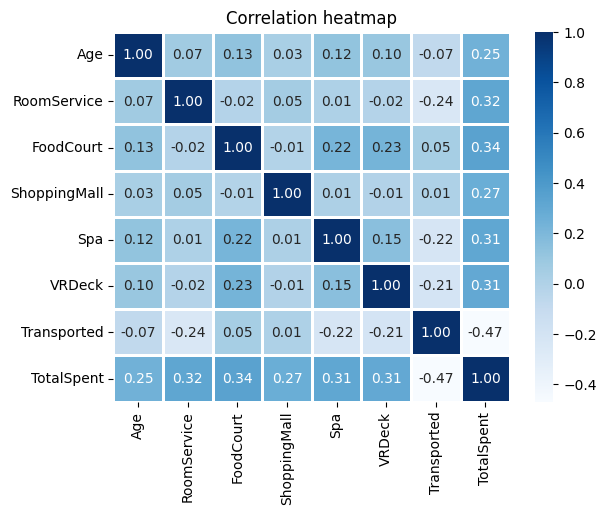

In [277]:
ax = sns.heatmap(data.corr(numeric_only=True), annot=True, cmap='Blues', linewidths=2)
for t in ax.texts: 
    t.set_text(f'{float(t.get_text()):.2f}')
plt.title('Correlation heatmap')
plt.show()

In [278]:
data.drop('TotalSpent', axis=1, inplace=True)

#### Построим базовый пайплайн

In [ ]:
class AddTeam(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        X['Team_num'] = X['PassengerId'].apply(lambda x: int(x.split('_')[0]))
        X['Pass_num'] = X['PassengerId'].apply(lambda x: int(x.split('_')[1]))
        team_counts = X['Team_num'].value_counts()
        X['HasTeam'] = (X['Team_num'].map(team_counts) > 1) | (X['Pass_num'] >= 2)
        X['HasTeam'] = X['HasTeam'].astype(float)
        X.drop(labels=['Team_num', 'PassengerId', 'Pass_num'], axis=1, inplace=True)
        return X

class ParseCabin(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = X.copy()
        X['CabinDeck'] = X['Cabin'].apply(lambda x: x.split('/')[0] if type(x) == str else np.nan)
        X['CabinNum'] = X['Cabin'].apply(lambda x: float(x.split('/')[1]) if type(x) == str else np.nan)
        X['CabinSide'] = X['Cabin'].apply(lambda x: x.split('/')[2] if type(x) == str else np.nan)
        X['CabinNum'] = pd.to_numeric(X['CabinNum'], errors='coerce')
        X.drop('Cabin', axis=1, inplace=True)
        return X
    
class AddTotalSpent(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = X.copy()
        X['TotalSpent'] = np.log1p(X[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1))
        return X


class ClearAndSetTypes(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = X.copy()
        dtypes = {
            'PassengerId' : 'string', 'HomePlanet' : 'category', 'CryoSleep' : 'float32', 'Cabin' : 'string', 'Destination' : 'category', 'Age' : 'float32', 'VIP' : 'float32',
            'RoomService' : 'float32', 'FoodCourt' : 'float32', 'ShoppingMall' : 'float32', 'Spa' : 'float32', 'VRDeck' : 'float32', 'Transported' : 'int8'
        }
        cols_for_drop = []
        for col in  X.columns:
            if col in dtypes:
                X[col] = X[col].astype(dtypes[col])
            else:
                cols_for_drop.append(col)

        X.drop(labels=cols_for_drop, axis=1, inplace=True)
        X = X.replace({pd.NA: np.nan})
        return X

In [284]:
num_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalSpent', 'CabinNum']
cat_features = ['HomePlanet', 'Destination', 'VIP', 'CabinDeck', 'CabinSide', 'CryoSleep', 'HasTeam']

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    # ('scaler', MinMaxScaler())
]).set_output(transform='pandas')

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder())
]).set_output(transform='pandas')

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
]).set_output(transform='pandas')

pipe = Pipeline(steps=[
    ('clear', ClearAndSetTypes()),
    ('add_teams', AddTeam()),
    ('parse_cabin', ParseCabin()),
    ('add_total_spent', AddTotalSpent()),
    ('preprocessor', preprocessor)
])

In [285]:
a = pipe.fit_transform(data)

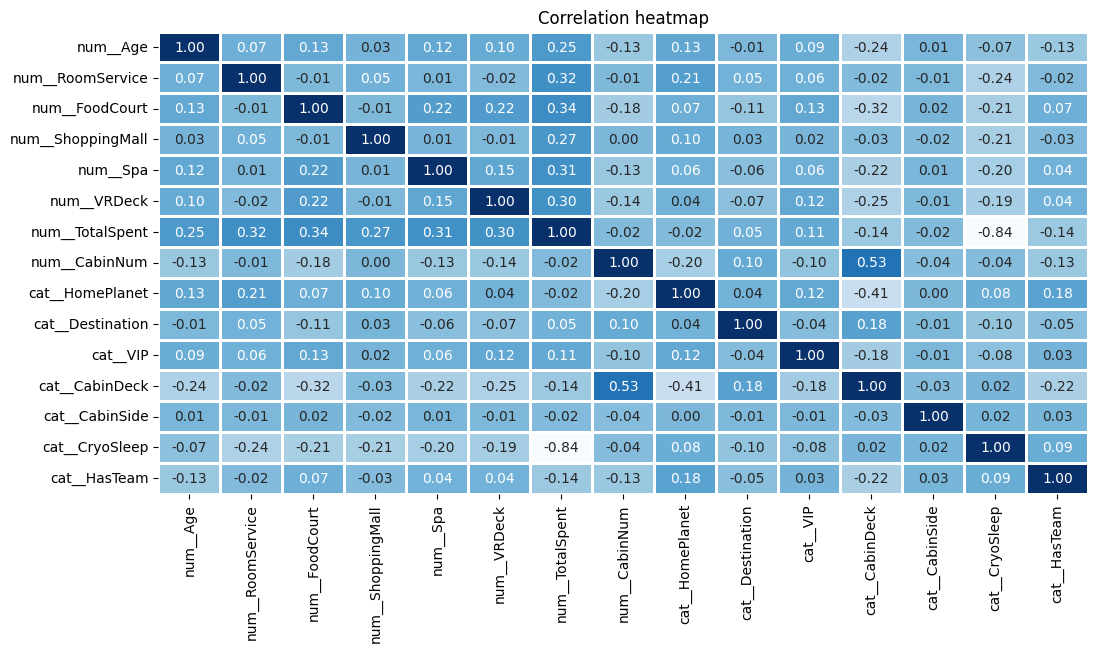

In [287]:
plt.figure(figsize=(12,6))
ax = sns.heatmap(a.corr(), annot=True, cmap='Blues', linewidths=2, cbar=False)
for t in ax.texts: 
    t.set_text(f'{float(t.get_text()):.2f}')
plt.title('Correlation heatmap')
plt.show()

In [288]:
train, test = train_test_split(data, test_size=0.3, random_state=33)
X_train, y_train = train.drop('Transported', axis=1), train['Transported']
X_test, y_test = test.drop('Transported', axis=1), test['Transported']

X_train = pipe.fit_transform(X_train)
X_test = pipe.transform(X_test)

In [289]:
base_rf = RandomForestClassifier(random_state=14)
base_rf.fit(X_train, y_train)
base_rf_train_preds, base_rf_train_probs = base_rf.predict(X_train), base_rf.predict_proba(X_train)
base_rf_test_preds, base_rf_test_probs = base_rf.predict(X_test), base_rf.predict_proba(X_test)

In [290]:
def evaluate(y_true, y_preds, model_name, set):
    print(f'{model_name} {set} accuracy score = {accuracy_score(y_true, y_preds):.2f}')
    print(f'{model_name} precision score = {precision_score(y_true, y_preds):.2f}')
    print(f'{model_name} recall score = {recall_score(y_true, y_preds):.2f}')

In [291]:
evaluate(y_train, base_rf_train_preds, 'Base RF', 'train')
evaluate(y_test, base_rf_test_preds, 'Base RF', 'test')

Base RF train accuracy score = 1.00
Base RF precision score = 1.00
Base RF recall score = 1.00
Base RF test accuracy score = 0.80
Base RF precision score = 0.83
Base RF recall score = 0.77


In [292]:
def evaluate_plots(estimator, X, y, name='Model'):
    _, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    ConfusionMatrixDisplay.from_estimator(estimator, X, y, ax=axes[0], colorbar=False)
    RocCurveDisplay.from_estimator(estimator, X, y, ax=axes[1])
    PrecisionRecallDisplay.from_estimator(estimator, X, y, ax=axes[2], color='orange')
    axes[0].set_title('Confusion Matrix')
    axes[1].set_title('ROC-Curve')
    axes[1].plot([0,1], linestyle='--', color='black')
    axes[2].set_title('PR-Curve')
    axes[1].grid()
    axes[2].grid()
    plt.suptitle(f'Evaluation Metrics for {name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    

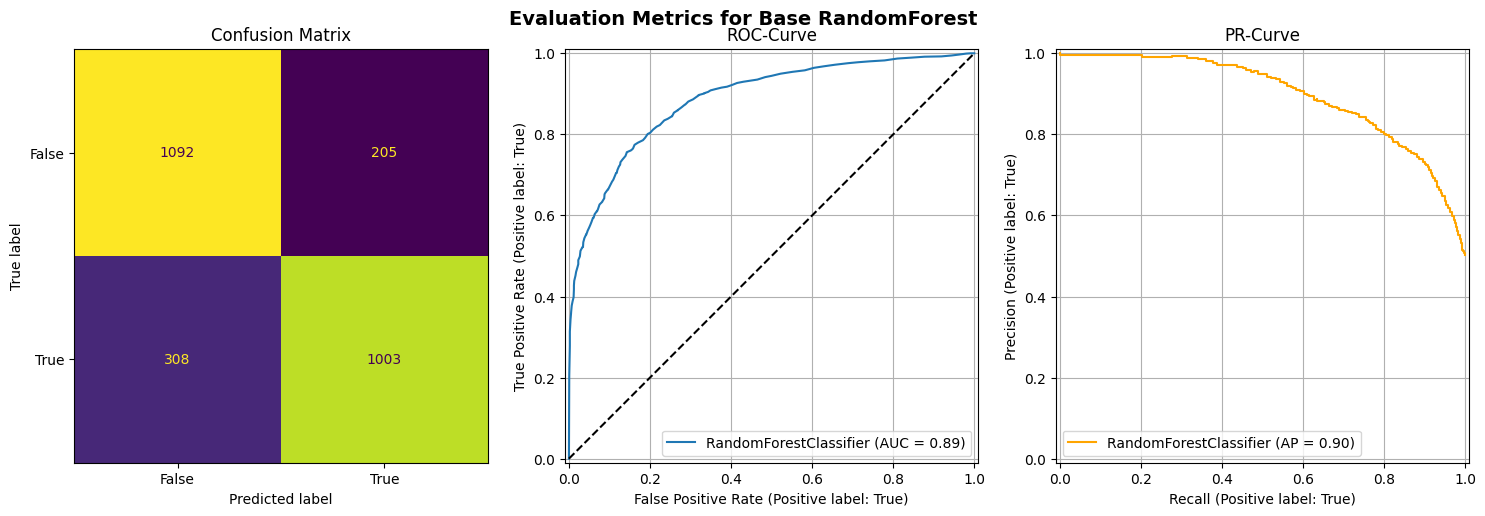

In [293]:
evaluate_plots(base_rf, X_test, y_test, name='Base RandomForest')

#### Стэкинг - три бустинга + логрег

In [294]:
catclf = CatBoostClassifier(
    iterations=300, learning_rate=0.05, depth=6, verbose=False, random_seed=33
)

xgbclf = xgb.XGBClassifier(
    n_estimators=300, learning_rate=0.05, max_depth=6, subsample=0.8,
    colsample_bytree=0.8, random_state=33, eval_metric='logloss'
)

lgbclf = lgb.LGBMClassifier(
    n_estimators=300, learning_rate=0.05, max_depth=-1, random_state=33, verbose=0
)

metamodel = LogisticRegression(max_iter=1000, random_state=33)

In [295]:
estimators = [
    ('lgb', lgbclf),
    ('xgb', xgbclf),
    ('cat', catclf)
]

stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=metamodel,
    cv=3,
    stack_method='predict_proba',
    n_jobs=-1
)

In [296]:
stacking_model.fit(X_train, y_train)

StackingClassifier(cv=3,
                   estimators=[('lgb',
                                LGBMClassifier(learning_rate=0.05,
                                               n_estimators=300,
                                               random_state=33, verbose=0)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.8, device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_typ...
                                              max_delta_step=None, max_depth=6,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=300, n_jobs=None,
                                              num_parallel_tree=None, ...)),
                               ('cat',
                                <catboost.core.CatBoostClassifier object at 0x118005eb0>)],
                   final_estimator=LogisticRegression(max_iter=1000,
                                                      random_state=33),
                   n_jobs=-1, stack_method='predict_proba')

In [297]:
evaluate(y_train, stacking_model.predict(X_train), 'Stacking', 'train')
evaluate(y_test, stacking_model.predict(X_test), 'Stacking', 'test')

Stacking train accuracy score = 0.87
Stacking precision score = 0.85
Stacking recall score = 0.89
Stacking test accuracy score = 0.81
Stacking precision score = 0.80
Stacking recall score = 0.84


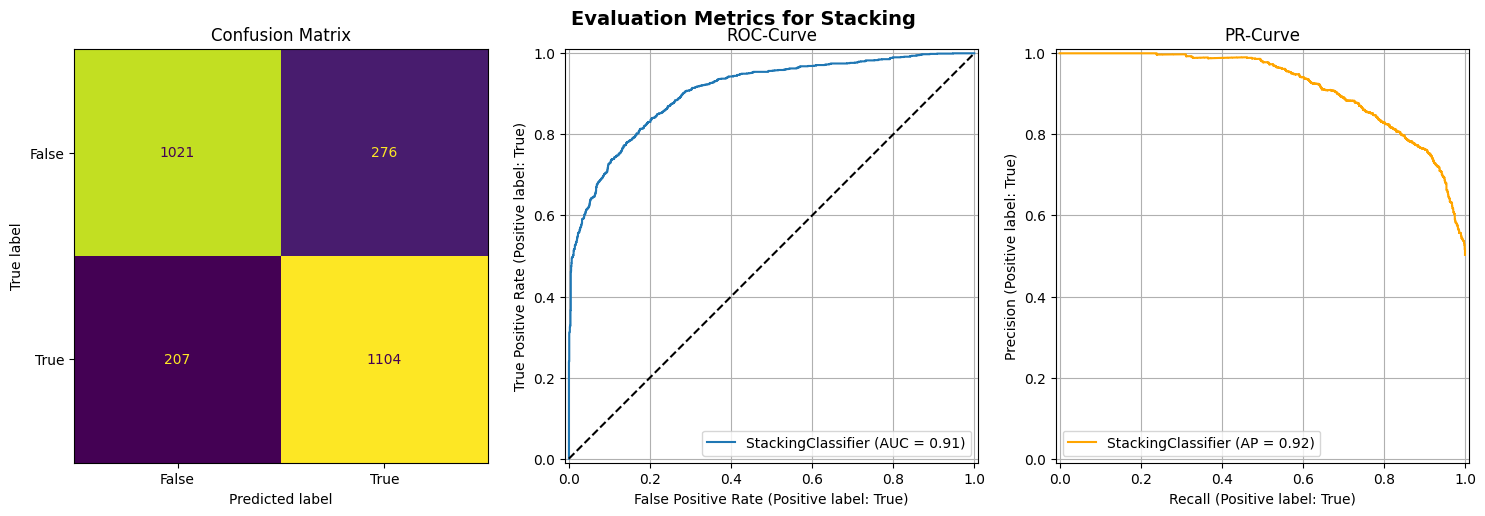

In [298]:
evaluate_plots(stacking_model, X_test, y_test, 'Stacking')

In [299]:
param_grid = {
    'lgb__n_estimators': [100, 300, 500],
    'lgb__learning_rate': [0.05, 0.1],
    'xgb__n_estimators' : [100, 300, 500],
    'xgb__max_depth': [2, 4, 6, 8],
    'xgb__subsample': [0.8, 1.0],
    'cat__iterations' : [100, 300, 500],
    'cat__depth': [2, 4, 6, 8],
    'cat__learning_rate': [0.03, 0.05, 0.1],
    'final_estimator__C': [0.1, 1, 10]
}

search = RandomizedSearchCV(
    estimator=stacking_model,
    param_distributions=param_grid,
    n_iter=20,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

search.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3,
                   estimator=StackingClassifier(cv=3,
                                                estimators=[('lgb',
                                                             LGBMClassifier(learning_rate=0.05,
                                                                            n_estimators=300,
                                                                            random_state=33,
                                                                            verbose=0)),
                                                            ('xgb',
                                                             XGBClassifier(base_score=None,
                                                                           booster=None,
                                                                           callbacks=None,
                                                                           colsample_bylevel=None,
                                                                           colsample_bynode=None,
                                                                           colsample_bytree=0.8,
                                                                           device=None,
                                                                           early_stopping_rounds=None,
                                                                           enable_categorical=False...
                                                stack_method='predict_proba'),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'cat__depth': [2, 4, 6, 8],
                                        'cat__iterations': [100, 300, 500],
                                        'cat__learning_rate': [0.03, 0.05, 0.1],
                                        'final_estimator__C': [0.1, 1, 10],
                                        'lgb__learning_rate': [0.05, 0.1],
                                        'lgb__n_estimators': [100, 300, 500],
                                        'xgb__max_depth': [2, 4, 6, 8],
                                        'xgb__n_estimators': [100, 300, 500],
                                        'xgb__subsample': [0.8, 1.0]},
                   scoring='accuracy', verbose=1)

In [300]:
search.best_params_

{'xgb__subsample': 1.0,
 'xgb__n_estimators': 300,
 'xgb__max_depth': 2,
 'lgb__n_estimators': 500,
 'lgb__learning_rate': 0.1,
 'final_estimator__C': 10,
 'cat__learning_rate': 0.1,
 'cat__iterations': 100,
 'cat__depth': 6}

In [301]:
best_stacking = search.best_estimator_

In [302]:
evaluate(y_train, best_stacking.predict(X_train), 'Best Stacking', 'train')
evaluate(y_test, best_stacking.predict(X_test), 'Best Stacking', 'test')

Best Stacking train accuracy score = 0.85
Best Stacking precision score = 0.84
Best Stacking recall score = 0.88
Best Stacking test accuracy score = 0.81
Best Stacking precision score = 0.80
Best Stacking recall score = 0.84


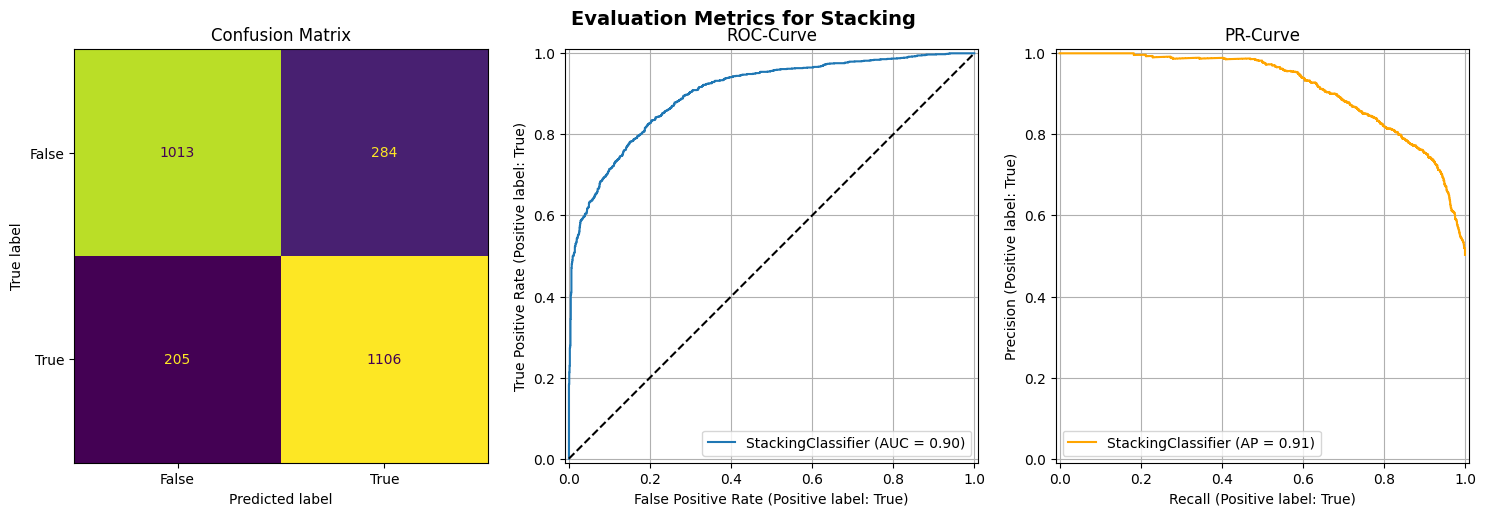

In [303]:
evaluate_plots(best_stacking, X_test, y_test, 'Stacking')

#### Снова загрузим данные, обучим модель на всем train сете и сделаем предсказания

In [304]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [305]:
X_train, y_train = train.drop('Transported', axis=1), train['Transported']

In [306]:
X_train = pipe.fit_transform(X_train)
X_test = pipe.transform(test)

In [307]:
best_stacking.fit(X_train, y_train)

StackingClassifier(cv=3,
                   estimators=[('lgb',
                                LGBMClassifier(n_estimators=500,
                                               random_state=33, verbose=0)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.8, device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None,
                                              feature_wei...
                                              max_delta_step=None, max_depth=2,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=300, n_jobs=None,
                                              num_parallel_tree=None, ...)),
                               ('cat',
                                <catboost.core.CatBoostClassifier object at 0x118006960>)],
                   final_estimator=LogisticRegression(C=10, max_iter=1000,
                                                      random_state=33),
                   n_jobs=-1, stack_method='predict_proba')

In [308]:
test_preds = best_stacking.predict(X_test)

In [309]:
test['Transported'] = test_preds

In [310]:
test

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,True
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,False
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,True
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,True
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,True
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,False
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,True
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,True


In [311]:
submission = test[['PassengerId', 'Transported']]

In [312]:
submission.to_csv('submission_stacking4.csv', index=False)

#### Лучшая посылка - 0.80593 accuracy и 206 местом в Leaderboard.